<a href="https://colab.research.google.com/github/oconcito8/deepLearning/blob/master/practica3deeplearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Práctica LAB3 IA Generativa - Imágenes

Autor: Carlos Ocón/ Pedro García.

Deep learning





Ejercicio 1: Entrenar un Variational Autoencoder con la base de dados keras.datasets.fashion_mnist (con las imágenes de Zalando). Una vez que entrenado el modelo, usar la red decoder para convertir vectores espaciales latentes arbitrarios en imágenes. (Mostrar un ejemplo del espacio latente)


Primero, se carga el conjunto de datos de Fashion MNIST utilizando la librería Keras. Este conjunto consta de imágenes en escala de grises de 28x28 píxeles que representan dígitos manuscritos (o en el caso de Fashion MNIST, artículos de moda).

In [ ]:
from tensorflow.keras.datasets import fashion_mnist
(x_train, _), (x_test, _) = fashion_mnist.load_data()

**Red encoder VAE**

El encoder toma imágenes y las procesa a través de capas convolucionales para reducir sus dimensiones y extraer características importantes. La salida pasa por una capa densa y se divide en dos partes: z_mean y z_log_var, que representan la media y la logaritmo de la varianza de una distribución de probabilidad (normal en este caso) desde la cual se muestreará el espacio latente z.

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

# Dimensionalidad del espacio latente: un plano 2D
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
# La imagen de entrada termina siendo codificada
# en estos dos parámetros: z_mean y z_log_var
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder")

In [ ]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 14, 14, 32)           320       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 7, 7, 64)             18496     ['conv2d[0][0]']              
                                                                                                  
 flatten (Flatten)           (None, 3136)                 0         ['conv2d_1[0][0]']            
                                                                                            

El siguiente código es para **generar un punto espacial latente ``z``** usando ``z_mean`` y ``z_log_var``, los parámetros de la distribución estadística que se supone que produjeron ``input_img``:

**Capa de muestreo-espacio-latente (Latent-space-sampling)**

Esta es una capa personalizada que utiliza z_mean y z_log_var para muestrear un vector z del espacio latente, aplicando la técnica de reparametrización, esencial para el entrenamiento mediante backpropagation.

In [ ]:
import tensorflow as tf

class Sampler(layers.Layer):
    def call(self, z_mean, z_log_var):
        batch_size = tf.shape(z_mean)[0]
        z_size = tf.shape(z_mean)[1]
        # Dibuja un lote de vectores normales aleatorios.
        epsilon = tf.random.normal(shape=(batch_size, z_size))
        # Aplicar la fórmula de muestreo VAE
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

El siguiente código es la **implementación del decodificador**. Redimensionamos el vector ``z`` a las dimensiones de una imagen y luego usamos algunas capas de convolución para obtener una salida de imagen final que tiene las mismas dimensiones que la ``input_img`` original.

**Red de decodificadores VAE, asignando puntos de espacio latente a imágenes**

El decoder toma los vectores latentes muestreados y los transforma de nuevo en imágenes a través de una serie de capas densas y de convolución transpuesta, intentando reconstruir la imagen original desde su representación latente.

In [ ]:
# Entrada a través de la cual alimentaremos con z
latent_inputs = keras.Input(shape=(latent_dim,))
# Producimos la misma cantidad de coeficientes que
# teníamos al nivel de la capa Flatten en el codificador.
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
# Revertimos la capa Flatten del codificador.
x = layers.Reshape((7, 7, 64))(x)
# Revertimos las capas Conv2D del codificador.
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
# La salida termina con la forma (28, 28, 1)
decoder_outputs = layers.Conv2D(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

In [ ]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 64)        36928     
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 28, 28, 32)        18464     
 Transpose)                                                      
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 1)         289 

Creamos el **propio modelo VAE**. **Este es nuestro primer ejemplo de un modelo que no realiza aprendizaje supervisado** (un autoencoder es un ejemplo de **aprendizaje autosupervisado**, porque **utiliza sus entradas como objetivos**). Cada vez que se sale del aprendizaje supervisado clásico, es **común crear una subclase de la clase ``Model`` e implementar un ``train_ step()`` personalizado para especificar la nueva lógica de entrenamiento**.

**Modelo VAE con `train_step()` personalizado**

Se define un modelo VAE que integra el encoder, el sampler y el decoder. Implementa un método de entrenamiento personalizado (train_step) que calcula la pérdida de reconstrucción y la divergencia KL. Finalmente, se entrena el modelo en el conjunto de datos de Fashion MNIST.

In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.sampler = Sampler()
        # Usamos estas métricas para realizar un seguimiento
        # de los promedios de pérdida en cada época.
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    # Listamos las métricas en la propiedad metrics para permitir
    # que el modelo las restablezca después de cada época (o entre
    # varias llamadas a fit()/evaluate())
    def metrics(self):
        return [self.total_loss_tracker,
                self.reconstruction_loss_tracker,
                self.kl_loss_tracker]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(data)
            z = self.sampler(z_mean, z_log_var)
            reconstruction = decoder(z)
            # Sumamos la pérdida de reconstrucción sobre las
            # dimensiones espaciales (ejes 1 y 2) y tomamos
            # su media sobre la dimensión del lote.
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2)
                )
            )
            # Agreguamos el término de regularización
            # (divergencia de Kullback-Leibler).
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            total_loss = reconstruction_loss + tf.reduce_mean(kl_loss)
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "total_loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

Ahora **instanciamos y entrenar el modelo en dígitos MNIST**. Debido a que la **pérdida se soluciona en la capa personalizada**, **no especificamos una pérdida externa** en el momento de la compilación (``loss=None``), lo que a su vez significa que **no pasaremos los datos target durante el entrenamiento** (como podemos ver, solo pasamos ``x_train`` al modelo en ``fit()``).

**Entrenando la VAE**

In [ ]:
import numpy as np

(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
# Entrenamos en todos los dígitos MNIST, por lo que
# concatenamos las muestras de entrenamiento y prueba.
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
# Notemos que no pasamos un argumento de pérdida a compile(),
# ya que la pérdida ya es parte de train_step()
vae.compile(optimizer=keras.optimizers.Adam(), run_eagerly=True)
# Notemos que no pasamos objetivos (targets) en fit(),
# ya que train_step() no espera ninguno
vae.fit(mnist_digits, epochs=30, batch_size=128)

11490434/11490434 [==============================] - 2s 0us/step
Epoch 1/30


547/547 [==============================] - 37s 57ms/step - total_loss: 211.3297 - reconstruction_loss: 209.0723 - kl_loss: 2.2576
Epoch 2/30
547/547 [==============================] - 30s 54ms/step - total_loss: 179.2223 - reconstruction_loss: 176.0054 - kl_loss: 3.2168
Epoch 3/30
547/547 [==============================] - 37s 67ms/step - total_loss: 164.5370 - reconstruction_loss: 160.7402 - kl_loss: 3.7970
Epoch 4/30
547/547 [==============================] - 33s 61ms/step - total_loss: 159.5411 - reconstruction_loss: 155.6646 - kl_loss: 3.8765
Epoch 5/30
547/547 [==============================] - 31s 57ms/step - total_loss: 156.3841 - reconstruction_loss: 152.4854 - kl_loss: 3.8988
Epoch 6/30
547/547 [==============================] - 31s 56ms/step - total_loss: 154.5277 - reconstruction_loss: 150.6208 - kl_loss: 3.9069
Epoch 7/30
547/547 [==============================] - 30s 55ms/step - total_loss: 153.0087 - reconstruction_loss: 149.1185 - kl_loss: 3.8903
Epoch 8/30
547/547 [====

Una vez que se entrena el modelo, podemos **usar la red ``decoder``** para **convertir vectores espaciales latentes arbitrarios en imágenes**.

**Muestreo de una cuadrícula de imágenes del espacio latente 2D**

Posteriormente, se utiliza el decoder para generar imágenes a partir de vectores del espacio latente arbitrarios, visualizando una cuadrícula de imágenes que muestra cómo diferentes puntos en el espacio latente corresponden a diferentes imágenes reconstruidas.

1/1 [==============================] - 0s 17ms/step


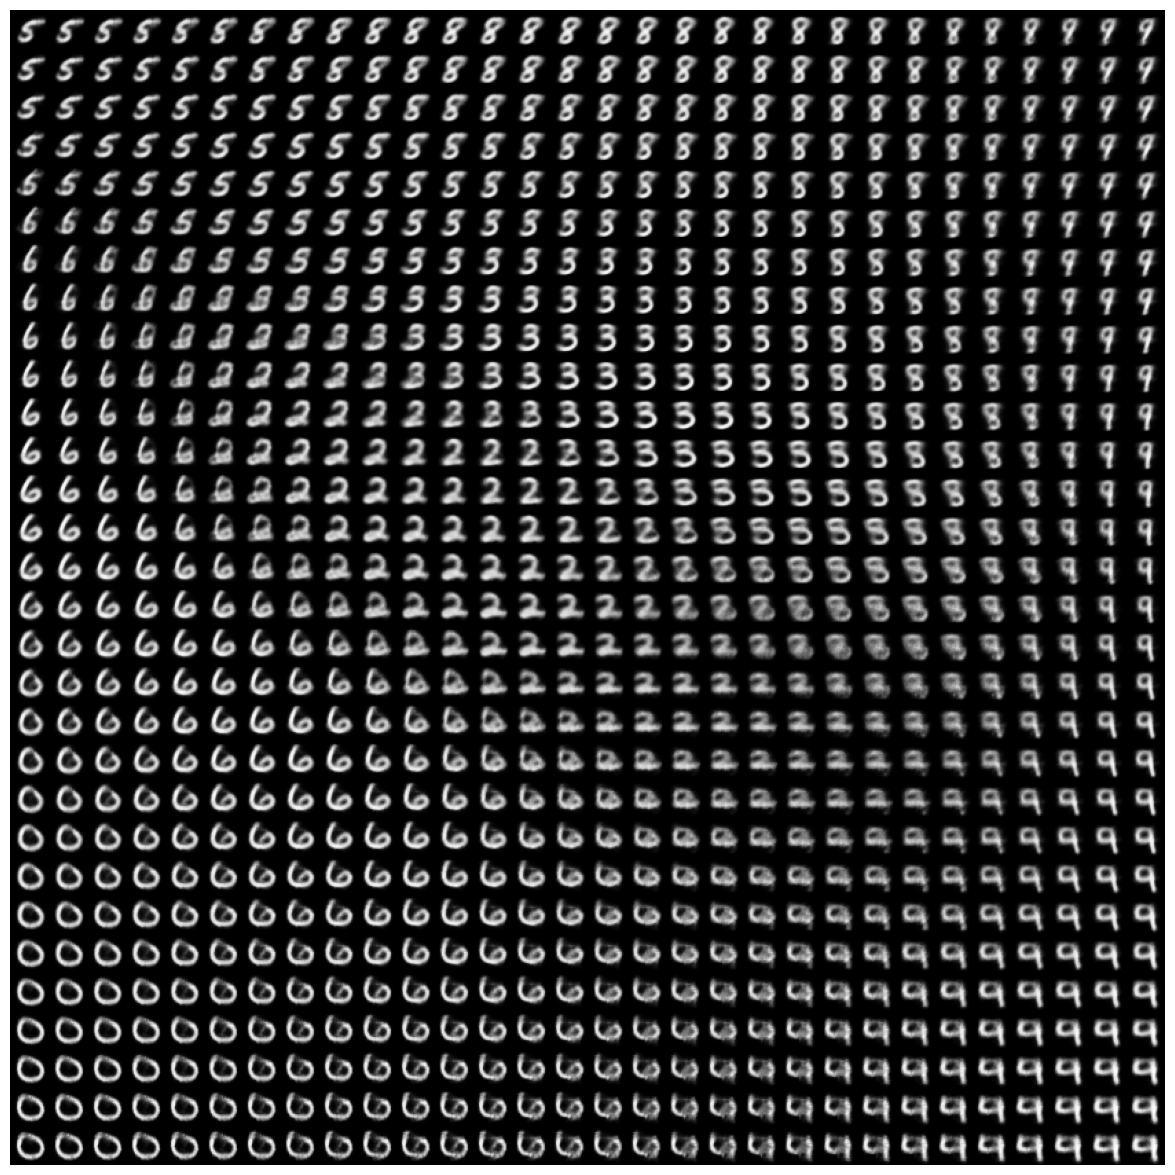

In [ ]:
import matplotlib.pyplot as plt

# Mostraremos una cuadrícula de
# 30 × 30 dígitos (900 dígitos en total)
n = 30
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# Muestree de puntos linealmente en una cuadrícula 2D.
grid_x = np.linspace(-1, 1, n)
grid_y = np.linspace(-1, 1, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        # Para cada ubicación, muestreamos un
        # dígito y lo agregamos a nuestra figura
        z_sample = np.array([[xi, yi]])
        x_decoded = vae.decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[
            i * digit_size : (i + 1) * digit_size,
            j * digit_size : (j + 1) * digit_size,
        ] = digit

plt.figure(figsize=(15, 15))
start_range = digit_size // 2
end_range = n * digit_size + start_range
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.axis("off")
plt.imshow(figure, cmap="Greys_r")

El VAE aprende a generar nuevas imágenes a partir de un espacio latente continuo y estructurado. Esto significa que pequeñas variaciones en el espacio latente resultan en cambios graduales en las imágenes generadas, lo que es útil para entender las características subyacentes aprendidas por el modelo y para aplicaciones como la edición de imágenes en el espacio latente.

En resumen, los VAE son poderosas herramientas para el modelado generativo que no solo aprenden a comprimir y descomprimir datos, sino también a modelar la distribución subyacente de esos datos, permitiendo la generación de nuevas instancias de datos que no están presentes en el conjunto de entrenamiento original.

Ejercicio 2: Dada la siguiente base de datos de zapatos (https://vision.cs.utexas.edu/projects/finegrained/utzap50k/ut-zap50k-images-square.zip). Entrenar una GAN para generar imágenes de zapatos nuevas.

## Introducción a las Redes Antagónicas Generativas (Generative Adversarial Networks - GANs)

**Modelo ``discriminator``**: **toma** como entrada una **imagen candidata** (real o sintética) **y la clasifica** en una de dos clases: **"generated image"** o **"real image that comes from the training set"**.

Uno de los muchos **problemas** que surgen comúnmente **con las GAN** es que el **generador se atasca con imágenes generadas que parecen ruido**. Una posible solución es **usar dropout en el discriminador**, eso es lo que haremos aquí.

**La red discriminadora (discriminator) GAN**

In [ ]:
from tensorflow.keras import layers

discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        # Una capa de Dropout: ¡un truco importante!
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)

In [ ]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         262272    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)            

### El generator

Modelo ``generator``: **convierta un vector** (desde el espacio latente; durante el entrenamiento se muestreará al azar) **en una imagen candidata**.

**La Red Generadora GAN**

In [ ]:
# El espacio latente estará formado por vectores de 128 dimensiones.
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        # Producimos la misma cantidad de coeficientes que teníamos
        # al nivel de la capa Flatten en el codificador.
        layers.Dense(8 * 8 * 128),
        # Revertimos la capa Flatten del codificador
        layers.Reshape((8, 8, 128)),
        # Revertimos las capas Conv2D del codificador.
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        # Usamos LeakyReLU como nuestra activación
        layers.LeakyReLU(alpha=0.2),
        # Revertimos las capas Conv2D del codificador.
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        # Usamos LeakyReLU como nuestra activación
        layers.LeakyReLU(alpha=0.2),
        # Revertimos las capas Conv2D del codificador.
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        # Usamos LeakyReLU como nuestra activación
        layers.LeakyReLU(alpha=0.2),
        # La salida termina con la forma (28, 28, 1)
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)

In [ ]:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 8192)              1056768   
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 16, 16, 128)       262272    
 anspose)                                                        
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 32, 32, 256)       524544    
 Transpose)                                                      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 256)       0 

### La Red Antagónica (Adversarial)

Finalmente, **configuraremos el GAN**, que **encadena el generador y el discriminador**. Cuando **se entrena**, **este modelo moverá el generador en una dirección que mejora su capacidad para engañar al discriminador**. El **modelo convierte los puntos de espacio latente en una decisión de clasificación**, "fake" o "real", y **está destinado a ser entrenado con etiquetas** que siempre son **"estas son imágenes reales"**. Entonces, **el ``gan`` de entrenamiento actualizará los pesos del ``generator`` de una manera que hace que el ``discriminator`` sea más probable que prediga "real" cuando mira imágenes falsas**.

**Ciclo de entranamiento esquemático**. Para cada época, hacemos lo siguiente:
1. **Dibujar puntos aleatorios en el espacio latente** (**ruido aleatorio**).
2. **Generamos imágenes con ``generator`` usando este ruido aleatorio**.
3. **Mezclamos** las **imágenes generadas** **con** las **reales**.
4. **Entrenamos al ``discriminator``** utilizando estas **imágenes mezcladas**, **con los objetivos correspondientes**: ya sea "**real**" (para las imágenes reales) o "**fake**" (para las **imágenes generadas**).
5. **Dibujamos nuevos puntos aleatorios en el espacio latente**.
6. **Entrenamos el ´´generator´´ usando estos vectores aleatorios**, con **objetivos que dicen "estas son imágenes reales"**. **Esto actualiza los pesos del generador para moverlos para que el discriminador prediga "estas son imágenes reales" para las imágenes generadas: esto entrena al generador para engañar al discriminador**.

* Lo implementamos usando una **subclase de ``Model`` con un ``train_step()`` personalizado** (como hicimos con VAE)
* Usaremos **dos optimizadores** (uno para el **generador** y otro para el **discriminador**), por lo que también **sobreescribiremos ``compile()`` para permitir el paso de los dos optimizadores**.

**El `Model` GAN**

In [ ]:
import tensorflow as tf
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        # Configura métricas para rastrear las dos
        # pérdidas en cada época de entrenamiento
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Muestrea puntos aleatorios en el espacio latente
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim))
        # Los decodifica a imágenes falsas
        generated_images = self.generator(random_latent_vectors)
        # Los combina con imágenes reales
        combined_images = tf.concat([generated_images, real_images], axis=0)
        # Ensambla etiquetas, discriminando imágenes reales de falsas
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))],
            axis=0
        )
        # Agrega ruido aleatorio a las etiquetas: ¡un truco importante!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Entrenamos al discriminador
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        random_latent_vectors = tf.random.normal(
            # Muestrea puntos aleatorios en el espacio latente
            shape=(batch_size, self.latent_dim))

        # Ensambla etiquetas de imágenes reales
        misleading_labels = tf.zeros((batch_size, 1))

        # Entrena al generador
        with tf.GradientTape() as tape:
            predictions = self.discriminator(
                self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(
            zip(grads, self.generator.trainable_weights))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {"d_loss": self.d_loss_metric.result(),
                "g_loss": self.g_loss_metric.result()}

**Antes** **de** comenzar a **entrenar**, **configuramos una callback para monitorizar nuestros resultados**: **usará el generador para crear y guardar una cantidad de imágenes falsas al final de cada época**.

**Una callback que muestra imágenes generadas durante el entrenamiento**

In [ ]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.utils.array_to_img(generated_images[i])
            img.save(f"generated_img_{epoch:03d}_{i}.png")

Finalmente, podemos comenzar a entrenar

**Compilando y entrenando la GAN**

In [ ]:
# Comenzaremos a obtener resultados interesantes después de la época 20.
epochs = 100

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)

Epoch 1/100
1565/1565 [==============================] - 417s 257ms/step - d_loss: 0.2470 - g_loss: 8.6760
Epoch 2/100
1565/1565 [==============================] - 402s 257ms/step - d_loss: 0.6287 - g_loss: 1.0957
Epoch 3/100
1565/1565 [==============================] - 401s 256ms/step - d_loss: 0.6229 - g_loss: 1.1034
Epoch 4/100
1565/1565 [==============================] - 401s 256ms/step - d_loss: 0.6292 - g_loss: 1.0863
Epoch 5/100
1565/1565 [==============================] - 401s 256ms/step - d_loss: 0.6525 - g_loss: 0.9562
Epoch 6/100
1565/1565 [==============================] - 399s 255ms/step - d_loss: 0.6664 - g_loss: 0.9065
Epoch 7/100
1565/1565 [==============================] - 400s 256ms/step - d_loss: 0.6657 - g_loss: 0.9165
Epoch 8/100
1565/1565 [==============================] - 400s 255ms/step - d_loss: 0.6493 - g_loss: 1.0608
Epoch 9/100
1565/1565 [==============================] - 400s 255ms/step - d_loss: 0.6513 - g_loss: 0.9059
Epoch 10/100
1565/1565 [=============

Durante el **entrenamiento**, es posible que observemos que la pérdida adversaria (**adversarial loss**) **comienza a aumentar** considerablemente, mientras que la pérdida discriminatoria (**discriminative loss**) **tiende a cero**: **el discriminador puede terminar dominando al generador**. Si ese es el caso, podemos **intentar reducir la tasa de aprendizaje del discriminador** y **aumentar el dropout del discriminador**.

**Algunas imágenes generadas alrededor de la época 30**

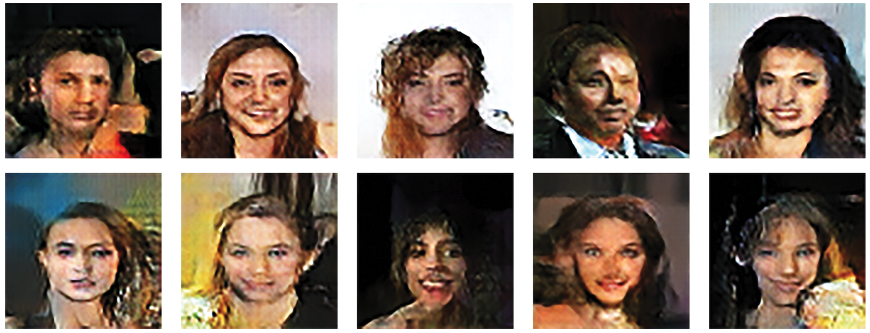

### Resumen GAN

* Una **GAN** consta de una **red generadora junto con una red discriminadora**. El **discriminador se entrena para diferenciar entre la salida del generador y las imágenes reales de un conjunto de datos de entrenamiento**, y el **generador se entrena para engañar al discriminador**. Sorprendentemente, **el generador nunca ve imágenes del conjunto de entrenamiento directamente**; **la información que tiene sobre los datos proviene del discriminador**.
* Las **GAN** son **difíciles de entrenar**: **proceso dinámico en lugar de un simple proceso de descenso de gradiente** con un panorama de **pérdidas fijas**. Lograr que una GAN se entrene correctamente requiere el uso de una serie de trucos heurísticos, así como una gran cantidad de ajustes.
* Las **GAN pueden producir potencialmente imágenes muy realistas**. Pero a diferencia de los VAE, **el espacio latente que aprenden no tiene una estructura continua ordenada** y, por lo tanto, **puede no ser adecuado para ciertas aplicaciones prácticas, como la edición de imágenes a través de vectores de concepto de espacio latente**.

Estas pocas técnicas cubren solo los **conceptos básicos** de este campo en rápida expansión. Hay mucho más por descubrir: el **aprendizaje profundo generativo merece un libro completo**.

## Introducción a las Redes Antagónicas Generativas (Generative Adversarial Networks - GANs)

### Metiendo mano en el conjunto de datos de CelebA

Conjunto de datos: http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html:

**Obteniendo los datos de CelebA**

In [1]:
# Creamos el directorio de trabajo
!mkdir zapatos_gan

# Descargamos los datos directamente desde la URL
!wget https://vision.cs.utexas.edu/projects/finegrained/utzap50k/ut-zap50k-images-square.zip -O zapatos_gan/data.zip

# Descomprimimos los datos
!unzip -qq zapatos_gan/data.zip -d zapatos_gan

--2024-05-06 17:35:27--  https://vision.cs.utexas.edu/projects/finegrained/utzap50k/ut-zap50k-images-square.zip
Resolving vision.cs.utexas.edu (vision.cs.utexas.edu)... 128.83.130.185
Connecting to vision.cs.utexas.edu (vision.cs.utexas.edu)|128.83.130.185|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 144233542 (138M) [application/zip]
Saving to: ‘zapatos_gan/data.zip’

zapatos_gan/data.zi 100%[===================>] 137.55M  2.40MB/s    in 81s     

2024-05-06 17:36:48 (1.70 MB/s) - ‘zapatos_gan/data.zip’ saved [144233542/144233542]



Usamos **``image_dataset_from_directory`` para convertirlo en un dataset.** Dado que **solo necesitamos las imágenes, no hay etiquetas**, especificaremos **``label_mode=None``**.

**Creamos un dataset a partir de un directorio de imágenes**

In [2]:
from tensorflow import keras
dataset = keras.utils.image_dataset_from_directory(
    "zapatos_gan",
    # Solo se devolverán las imágenes, sin etiquetas.
    label_mode=None,
    image_size=(64, 64),
    batch_size=32,
    # Cambiaremos el tamaño de las imágenes a 64 × 64
    # usando una combinación inteligente de recorte y
    # cambio de tamaño para preservar la relación de
    # aspecto.
    smart_resize=True)

Found 50066 files belonging to 1 classes.


Finalmente, cambiamos la **escala de las imágenes al rango ``[0-1]``**

**Rescalamos las imágenes**

In [3]:
dataset = dataset.map(lambda x: x / 255.)

**Mostramos la primera imagen**

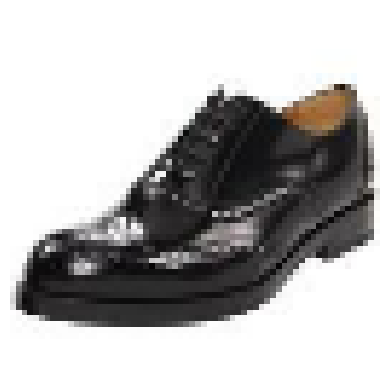

In [4]:
import matplotlib.pyplot as plt
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

### El discriminator

**Modelo ``discriminator``**: **toma** como entrada una **imagen candidata** (real o sintética) **y la clasifica** en una de dos clases: **"generated image"** o **"real image that comes from the training set"**.

Uno de los muchos **problemas** que surgen comúnmente **con las GAN** es que el **generador se atasca con imágenes generadas que parecen ruido**. Una posible solución es **usar dropout en el discriminador**, eso es lo que haremos aquí.

**La red discriminadora (discriminator) GAN**

In [5]:
from tensorflow.keras import layers

discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        # Una capa de Dropout: ¡un truco importante!
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)

In [6]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         262272    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)            

### El generator

Modelo ``generator``: **convierta un vector** (desde el espacio latente; durante el entrenamiento se muestreará al azar) **en una imagen candidata**.

**La Red Generadora GAN**

In [7]:
# El espacio latente estará formado por vectores de 128 dimensiones.
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        # Producimos la misma cantidad de coeficientes que teníamos
        # al nivel de la capa Flatten en el codificador.
        layers.Dense(8 * 8 * 128),
        # Revertimos la capa Flatten del codificador
        layers.Reshape((8, 8, 128)),
        # Revertimos las capas Conv2D del codificador.
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        # Usamos LeakyReLU como nuestra activación
        layers.LeakyReLU(alpha=0.2),
        # Revertimos las capas Conv2D del codificador.
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        # Usamos LeakyReLU como nuestra activación
        layers.LeakyReLU(alpha=0.2),
        # Revertimos las capas Conv2D del codificador.
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        # Usamos LeakyReLU como nuestra activación
        layers.LeakyReLU(alpha=0.2),
        # La salida termina con la forma (28, 28, 1)
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)

In [8]:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 8192)              1056768   
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 16, 16, 128)       262272    
 anspose)                                                        
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 32, 32, 256)       524544    
 Transpose)                                                      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 256)       0 

### La Red Antagónica (Adversarial)

Finalmente, **configuraremos el GAN**, que **encadena el generador y el discriminador**. Cuando **se entrena**, **este modelo moverá el generador en una dirección que mejora su capacidad para engañar al discriminador**. El **modelo convierte los puntos de espacio latente en una decisión de clasificación**, "fake" o "real", y **está destinado a ser entrenado con etiquetas** que siempre son **"estas son imágenes reales"**. Entonces, **el ``gan`` de entrenamiento actualizará los pesos del ``generator`` de una manera que hace que el ``discriminator`` sea más probable que prediga "real" cuando mira imágenes falsas**.

**Ciclo de entranamiento esquemático**. Para cada época, hacemos lo siguiente:
1. **Dibujar puntos aleatorios en el espacio latente** (**ruido aleatorio**).
2. **Generamos imágenes con ``generator`` usando este ruido aleatorio**.
3. **Mezclamos** las **imágenes generadas** **con** las **reales**.
4. **Entrenamos al ``discriminator``** utilizando estas **imágenes mezcladas**, **con los objetivos correspondientes**: ya sea "**real**" (para las imágenes reales) o "**fake**" (para las **imágenes generadas**).
5. **Dibujamos nuevos puntos aleatorios en el espacio latente**.
6. **Entrenamos el ´´generator´´ usando estos vectores aleatorios**, con **objetivos que dicen "estas son imágenes reales"**. **Esto actualiza los pesos del generador para moverlos para que el discriminador prediga "estas son imágenes reales" para las imágenes generadas: esto entrena al generador para engañar al discriminador**.

* Lo implementamos usando una **subclase de ``Model`` con un ``train_step()`` personalizado** (como hicimos con VAE)
* Usaremos **dos optimizadores** (uno para el **generador** y otro para el **discriminador**), por lo que también **sobreescribiremos ``compile()`` para permitir el paso de los dos optimizadores**.

**El `Model` GAN**

In [9]:
import tensorflow as tf
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        # Configura métricas para rastrear las dos
        # pérdidas en cada época de entrenamiento
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Muestrea puntos aleatorios en el espacio latente
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim))
        # Los decodifica a imágenes falsas
        generated_images = self.generator(random_latent_vectors)
        # Los combina con imágenes reales
        combined_images = tf.concat([generated_images, real_images], axis=0)
        # Ensambla etiquetas, discriminando imágenes reales de falsas
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))],
            axis=0
        )
        # Agrega ruido aleatorio a las etiquetas: ¡un truco importante!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Entrenamos al discriminador
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        random_latent_vectors = tf.random.normal(
            # Muestrea puntos aleatorios en el espacio latente
            shape=(batch_size, self.latent_dim))

        # Ensambla etiquetas de imágenes reales
        misleading_labels = tf.zeros((batch_size, 1))

        # Entrena al generador
        with tf.GradientTape() as tape:
            predictions = self.discriminator(
                self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(
            zip(grads, self.generator.trainable_weights))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {"d_loss": self.d_loss_metric.result(),
                "g_loss": self.g_loss_metric.result()}

**Antes** **de** comenzar a **entrenar**, **configuramos una callback para monitorizar nuestros resultados**: **usará el generador para crear y guardar una cantidad de imágenes falsas al final de cada época**.

**Una callback que muestra imágenes generadas durante el entrenamiento**

In [10]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.utils.array_to_img(generated_images[i])
            img.save(f"generated_img_{epoch:03d}_{i}.png")

Finalmente, podemos comenzar a entrenar

**Compilando y entrenando la GAN**

In [ ]:
# Comenzaremos a obtener resultados interesantes después de la época 20.
epochs = 100

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)

Epoch 1/100
1565/1565 [==============================] - 417s 257ms/step - d_loss: 0.2470 - g_loss: 8.6760
Epoch 2/100
1565/1565 [==============================] - 402s 257ms/step - d_loss: 0.6287 - g_loss: 1.0957
Epoch 3/100
1565/1565 [==============================] - 401s 256ms/step - d_loss: 0.6229 - g_loss: 1.1034
Epoch 4/100
1565/1565 [==============================] - 401s 256ms/step - d_loss: 0.6292 - g_loss: 1.0863
Epoch 5/100
1565/1565 [==============================] - 401s 256ms/step - d_loss: 0.6525 - g_loss: 0.9562
Epoch 6/100
1565/1565 [==============================] - 399s 255ms/step - d_loss: 0.6664 - g_loss: 0.9065
Epoch 7/100
1565/1565 [==============================] - 400s 256ms/step - d_loss: 0.6657 - g_loss: 0.9165
Epoch 8/100
1565/1565 [==============================] - 400s 255ms/step - d_loss: 0.6493 - g_loss: 1.0608
Epoch 9/100
1565/1565 [==============================] - 400s 255ms/step - d_loss: 0.6513 - g_loss: 0.9059
Epoch 10/100
1565/1565 [=============

Durante el **entrenamiento**, es posible que observemos que la pérdida adversaria (**adversarial loss**) **comienza a aumentar** considerablemente, mientras que la pérdida discriminatoria (**discriminative loss**) **tiende a cero**: **el discriminador puede terminar dominando al generador**. Si ese es el caso, podemos **intentar reducir la tasa de aprendizaje del discriminador** y **aumentar el dropout del discriminador**.

**Algunas imágenes generadas alrededor de la época 30**

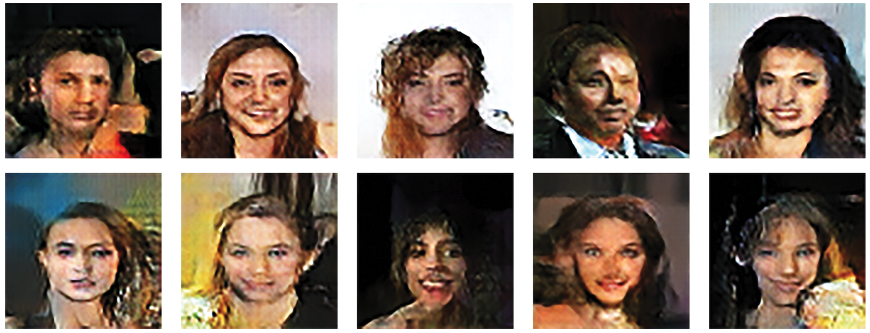

### Resumen GAN

* Una **GAN** consta de una **red generadora junto con una red discriminadora**. El **discriminador se entrena para diferenciar entre la salida del generador y las imágenes reales de un conjunto de datos de entrenamiento**, y el **generador se entrena para engañar al discriminador**. Sorprendentemente, **el generador nunca ve imágenes del conjunto de entrenamiento directamente**; **la información que tiene sobre los datos proviene del discriminador**.
* Las **GAN** son **difíciles de entrenar**: **proceso dinámico en lugar de un simple proceso de descenso de gradiente** con un panorama de **pérdidas fijas**. Lograr que una GAN se entrene correctamente requiere el uso de una serie de trucos heurísticos, así como una gran cantidad de ajustes.
* Las **GAN pueden producir potencialmente imágenes muy realistas**. Pero a diferencia de los VAE, **el espacio latente que aprenden no tiene una estructura continua ordenada** y, por lo tanto, **puede no ser adecuado para ciertas aplicaciones prácticas, como la edición de imágenes a través de vectores de concepto de espacio latente**.

Estas pocas técnicas cubren solo los **conceptos básicos** de este campo en rápida expansión. Hay mucho más por descubrir: el **aprendizaje profundo generativo merece un libro completo**.

## Resumen Final Deep Learning Generativo

* Podemos usar un **modelo de secuencia-a-secuencia** para **generar datos de secuencia**, un paso a la vez. Esto es aplicable a la **generación de texto**, pero también a la generación de **música** nota por nota o **cualquier otro tipo de datos de series temporales**.
* **DeepDream** funciona **maximizando las activaciones de la capa de convnet a través del ascenso de gradiente en el espacio de entrada**.
* En el **algoritmo de transferencia de estilo**, una **imagen de contenido** y una **imagen de estilo** se **combinan mediante un descenso de gradiente** para **producir una imagen con las características de alto nivel de la imagen de contenido** y las **características locales de la imagen de estilo**.
* **VAE** y **GAN** son modelos que **aprenden un espacio latente de imágenes** y luego **pueden soñar con imágenes completamente nuevas al tomar muestras del espacio latente**. Los **vectores conceptuales** en el espacio latente pueden incluso **usarse para la edición de imágenes**.